In [4]:
from analysis_helpers import *
import pylab as plt

%matplotlib qt

folder = r'E:/CSHL/pita_g0/ks25'

spike_times_samples,spike_clusters,spike_amplitudes,spike_positions,templates_raw,templates_position,cluster_groups = load_phy_folder(folder)

In [5]:
# the spikes need to be converted to time (they are in samples now)
# we do this by dividing by the sampling rate
# lets load the sampling rate from the file we saved earlier

syncs = glob(pjoin(folder,'..','experiment_syncs.h5'))[0]
import h5py as h5

with h5.File(syncs,'r') as fd:
    srate = fd['sampling_rate'][()]
    visual_onsets = fd['visual_sync_s'][()]
    opto_onsets = fd['opto_sync_s'][()]
spike_times = spike_times_samples/srate



In [2]:
# load trial information
stimlog = pd.read_csv(glob(pjoin(folder,'..','logs','*.gratings.csv'))[0]) # this has the orientations
optolog = pd.read_csv(glob(pjoin(folder,'..','logs','*.gratings.opto.log'))[0]) # this has the orientations


In [164]:
tpre = 0.2
tpost = 1.5
# using only single cells. 
cluster_ids = cluster_groups.cluster_id[cluster_groups.group == 'good'].values
selection = np.isin(spike_clusters,cluster_ids)

clus = spike_clusters[selection]


# separate the spikes from each unit
timestamps = [spike_times[selection][clus == uclu] for uclu in np.unique(clus)]
# get the depths of each cluster
depths = [np.unique(spike_positions[selection][clus == uclu,1]) for uclu in np.unique(clus)]
depths = np.array(depths).flatten()

trig_ts = []
for sp in timestamps:
    trig_ts.append([])
    for o in visual_onsets:
        trig_ts[-1].append(sp[(sp>=(o-tpre)) & (sp<(o+tpost))] - o)

In [17]:
# Now lets have the triggered psths for all units
binsize = 0.01 # 10ms binsize
edges = np.arange(0,np.max(spike_times),binsize)

# Count the number of spikes in e.g. 10ms bins
unit_rates = []
for ts in timestamps:
    counts,bins = np.histogram(ts,edges)
    unit_rates.append(counts/binsize)
unit_rates = np.stack(unit_rates)    
unit_rates_time = edges[:-1]+np.diff(edges[:2])/2
print('We are going to look at {0} units'.format(unit_rates.shape[0]))

We are going to look at 66 units


In [39]:
# now get the triggered unit rates (all at once..)
trig_unit_rates = []
for o in visual_onsets:
    trig_unit_rates.append(unit_rates[:,(unit_rates_time>=(o-tpre)) & (unit_rates_time<(o+tpost))])
trig_unit_rates = np.stack(trig_unit_rates)
trig_unit_rates = trig_unit_rates.transpose([1,0,2]) # make the unit index the outer 

# Now we can look at all trials for a single cell
plt.imshow(trig_unit_rates[21][np.argsort(optolog.has_opto)],cmap = 'gray_r',aspect='auto',clim=[0,100],
          extent=[-tpre,tpost,0,trig_unit_rates.shape[1]],origin='bottom')

In [45]:
# we can quickly iterate over all cells like this
from ipywidgets import IntSlider,interact
plt.figure()
tt = plt.imshow(trig_unit_rates[21][np.argsort(optolog.has_opto)],cmap = 'gray_r',aspect='auto',clim=[0,100],
          extent=[-tpre,tpost,0,trig_unit_rates.shape[1]],origin='bottom')
# Now we can look at all trials for a single cell
@interact(iunit = IntSlider(min=0,max=trig_unit_rates.shape[0]-1,step=1))
def plot_raster(iunit = 2):
    tt.set_data(trig_unit_rates[iunit][np.argsort(optolog.has_opto)])
    return tt

interactive(children=(IntSlider(value=0, description='iunit', max=65), Output()), _dom_classes=('widget-intera…

In [215]:
# lets look at the orientation response
from ipywidgets import IntSlider,interact

# we can just reshape the triggered_unit_rastes estimate
# lets reshape it in NUNITS x N ORI STIMS x NTRIALS x NTIME 
nunits,ntrials,ntime = trig_unit_rates.shape
nstims = len(np.unique(stimlog.stim))

idx = np.argsort(stimlog.stim.values)
trig_unit_rates_ori = trig_unit_rates[:,idx].reshape([nunits,nstims,-1,ntime])
# Now lets put the opto trials all in the bottom of bottom
has_opto = optolog.iloc[idx].has_opto.values 
has_opto = has_opto.reshape(nstims,int(ntrials/nstims))
# Sort the trig_unit_rates_ori by if there is opto stim or not
for istim in range(nstims):
    idx = np.argsort(has_opto[istim])
    trig_unit_rates_ori[:,istim] = trig_unit_rates_ori[:,istim,idx]
# now put the first dimention to be units and second to be trials to help plotting
trig_unit_rates_ori = trig_unit_rates_ori.transpose([0,2,1,3])

plt.figure(figsize = [10,3])
tt = plt.imshow(trig_unit_rates_ori[21].reshape((int(ntrials/nstims),-1)),cmap = 'gray_r',aspect='auto',clim=[0,100],
          extent=[-tpre,tpost*nstims,0,ntrials/nstims],origin='bottom')
# plot a bar to show how many optotrias are plotted for each stim
for istim in range(nstims):
    nrows = ntrials/nstims
    plt.vlines(istim*tpost-tpre,0,nrows,color='w') #split the trials
    plt.vlines(istim*tpost+0.5,nrows,nrows-np.sum(has_opto[istim]),color='b') #split the trials

# Now we can look at all trials for a single cell and find a tuned cell
@interact(iunit = IntSlider(min=0,max=trig_unit_rates.shape[0]-1,step=1))
def plot_raster(iunit = 2):
    tt.set_data(trig_unit_rates_ori[iunit].reshape((int(ntrials/nstims),-1)))
    return tt


interactive(children=(IntSlider(value=0, description='iunit', max=65), Output()), _dom_classes=('widget-intera…

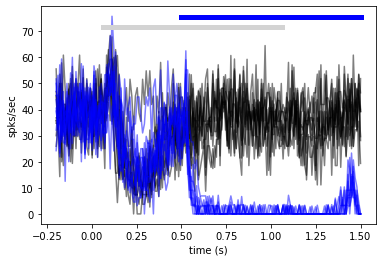

In [123]:
%matplotlib inline
# Lets compute the psth, now it is a bit more tricky 
# because we don't have equal number of opto and no-opto trials
# we just have to do it per trial
nunits,ntrials,nstims,ntime = trig_unit_rates_ori.shape
psth_mean = np.zeros([nunits,2,nstims,ntime]) # one for opto and one for no-opto
psth_sterr = np.zeros([nunits,2,nstims,ntime]) 
for istim in range(nstims):
    optoidx = np.sort(has_opto[istim])
    for sel in [0,1]: # select between no_opto and opto trials
        psth_mean[:,sel,istim] = trig_unit_rates_ori[:,optoidx==sel,istim].mean(axis = 1)
        psth_sterr[:,sel,istim] = trig_unit_rates_ori[:,optoidx==sel,istim].std(axis = 1)/np.sqrt(np.sum(optoidx==sel))

# Plot the single trials
iunit = 21
plt.figure()
t = np.linspace(-tpre,tpost,psth_mean.shape[-1])
plt.plot(t,psth_mean[iunit,0].T,color = 'k',alpha = 0.5)
plt.plot(t,psth_mean[iunit,1].T,color = 'blue',alpha = 0.5)
# plot the visual stim dur (we are using the arduino, there is a 60ms (measured) lag)
plt.plot([0.060,0.060+1],np.array([1,1])*np.max(plt.ylim())*0.9,
         lw = 5,color='lightgray')
plt.plot([0.5,0.5+1],np.array([1,1])*np.max(plt.ylim())*0.95,
         lw = 5,color='blue')
plt.xlabel('time (s)')
plt.ylabel('spks/sec');

In [214]:
# Plot the differnce between opto and no opto for all sites
%matplotlib qt
optodiff = np.diff(psth_mean.reshape(nunits,2,-1),axis = 1).squeeze()
plt.imshow(optodiff[np.argsort(depths)],
           aspect = 'auto',
           extent = [-tpre,nstims*(tpre+tpost),0,len(psth_mean)],
           clim=[-20,20],cmap='RdBu_r')
plt.ylabel('Units by depth')
plt.xticks([]);
# for istim in range(nstims):
#     plt.vlines(0.06+istim*(tpost+tpre),0,len(psth_mean))
#     plt.vlines(0.5+istim*(tpost+tpre),0,len(psth_mean))

In [230]:
# now lets plot the psth for each orientation and the rasters

fig = plt.figure(figsize = [10,3])
ax  = fig.add_axes([0.1,0.1,0.8,0.5])
tt = plt.imshow(trig_unit_rates_ori[21].reshape((int(ntrials/nstims),-1)),cmap = 'gray_r',aspect='auto',clim=[0,100],
          extent=[-tpre,(tpost+tpre)*nstims,0,ntrials/nstims],origin='bottom')
# plot a bar to show how many optotrias are plotted for each stim
for istim in range(nstims):
    nrows = ntrials/nstims
    plt.vlines(istim*(tpost+tpre)-tpre,0,nrows,color='w') #split the trials
    plt.vlines(istim*(tpost+tpre)+tpre+0.5,nrows,nrows-np.sum(has_opto[istim]),color='b') #split the trials

ax  = fig.add_axes([0.1,0.7,0.8,0.2],sharex=ax)
m = psth_mean[21,0].reshape(-1)
t = np.linspace(-tpre,nstims*(tpre+tpost),m.shape[0])
pp = plt.plot(t,m,'k')
# Now we can look at all trials for a single cell and find a tuned cell
@interact(iunit = IntSlider(min=0,max=trig_unit_rates.shape[0]-1,step=1))
def plot_raster(iunit = 2):
    tt.set_data(trig_unit_rates_ori[iunit].reshape((int(ntrials/nstims),-1)))
    ax.cla()
    m = psth_mean[iunit,0].reshape(-1)
    t = np.linspace(-tpre,nstims*(tpre+tpost),m.shape[0])
    ax.plot(t,m,'k')
    m = psth_mean[iunit,1].reshape(-1)
    t = np.linspace(-tpre,nstims*(tpre+tpost),m.shape[0])
    ax.plot(t,m,'b')

    return tt


interactive(children=(IntSlider(value=0, description='iunit', max=65), Output()), _dom_classes=('widget-intera…

In [85]:
# show the opto trials in different color
# plot the raster for a single units
iunit = 21
plt.figure()
triggered_spikes = trig_ts[iunit]
for i,ss in enumerate(triggered_spikes):
    color = 'black'
    if optolog.iloc[i].has_opto:
        color = 'blue'
    plt.vlines(ss,i,i+1,color = color)
plt.xlim([-tpre,tpost])
plt.ylim([0,len(stimlog)])

(0.0, 540.0)

In [97]:
# It is hard to see if units are supressed or not like that, lets sort the trials by opto or no opto
iunit = 21
plt.figure()
sel = np.argsort(optolog.has_opto)
triggered_spikes = [trig_ts[iunit][i] for i in sel] # arange the trials

for i,ss in enumerate(triggered_spikes):
    color = 'black'
    if optolog.iloc[sel].iloc[i].has_opto:
        color = 'blue'
    plt.vlines(ss,i,i+1,color = color)
plt.xlim([-tpre,tpost])
plt.ylim([0,len(stimlog)])
plt.ylabel('Number of trials')
plt.xlabel('Time from stim onset')

Text(0.5, 0, 'Time from stim onset')